TODO: PyTorch implementation, Visualize the CNN layers

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import classification_report

In [3]:
from keras.callbacks import EarlyStopping

from keras.metrics import (TruePositives, FalsePositives, TrueNegatives, FalseNegatives, 
                           BinaryAccuracy, Precision, Recall, AUC)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import fashion_mnist

In [4]:
plt.rcParams['figure.figsize'] = 10, 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Data normalization

In [6]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [7]:
X_train, X_test = X_train.astype("float32") / 255.0, X_test.astype("float32") / 255.0

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
len(X_train)

60000

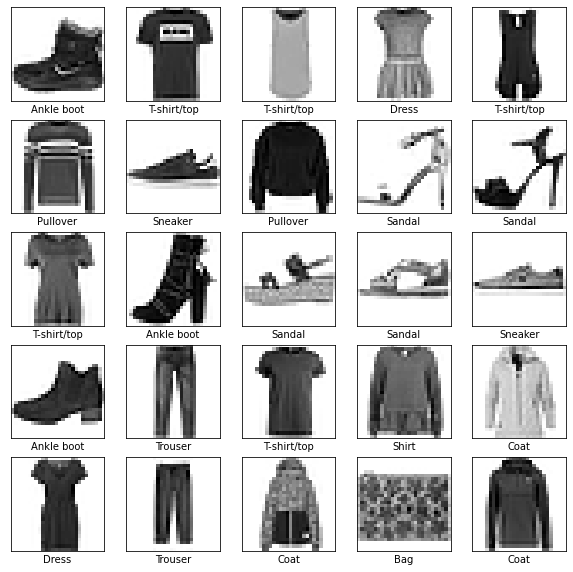

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()


## Keras

In [12]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [13]:
def make_model(input_shape, n_classes, metrics):
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, 
#                      kernel_size=(3, 3), 
#                      activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))

    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
#     # softmax classifier
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
#     model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=metrics)  

    model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=metrics)

    return model

In [14]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [15]:
input_shape = X_train.shape[1:]
n_classes = len(class_names)
EPOCHS = 10
BATCH_SIZE = 128

In [16]:
early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [17]:
model = make_model(input_shape, n_classes, METRICS)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

In [19]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_split = 0.2, 
    verbose=1)

Epoch 1/10
375/375 [==============================] - 131s 349ms/step - loss: 0.4944 - tp: 38962.0000 - fp: 6535.0000 - tn: 425465.0000 - fn: 9038.0000 - accuracy: 0.9676 - precision: 0.8564 - recall: 0.8117 - auc: 0.9837 - val_loss: 1.4480 - val_tp: 6585.0000 - val_fp: 3765.0000 - val_tn: 104235.0000 - val_fn: 5415.0000 - val_accuracy: 0.9235 - val_precision: 0.6362 - val_recall: 0.5487 - val_auc: 0.8967
Epoch 2/10
375/375 [==============================] - 131s 348ms/step - loss: 0.3060 - tp: 41955.0000 - fp: 4360.0000 - tn: 427640.0000 - fn: 6045.0000 - accuracy: 0.9783 - precision: 0.9059 - recall: 0.8741 - auc: 0.9931 - val_loss: 0.2624 - val_tp: 10737.0000 - val_fp: 936.0000 - val_tn: 107064.0000 - val_fn: 1263.0000 - val_accuracy: 0.9817 - val_precision: 0.9198 - val_recall: 0.8947 - val_auc: 0.9949
Epoch 3/10
375/375 [==============================] - 132s 351ms/step - loss: 0.2615 - tp: 42853.0000 - fp: 3740.0000 - tn: 428260.0000 - fn: 5147.0000 - accuracy: 0.9815 - precision

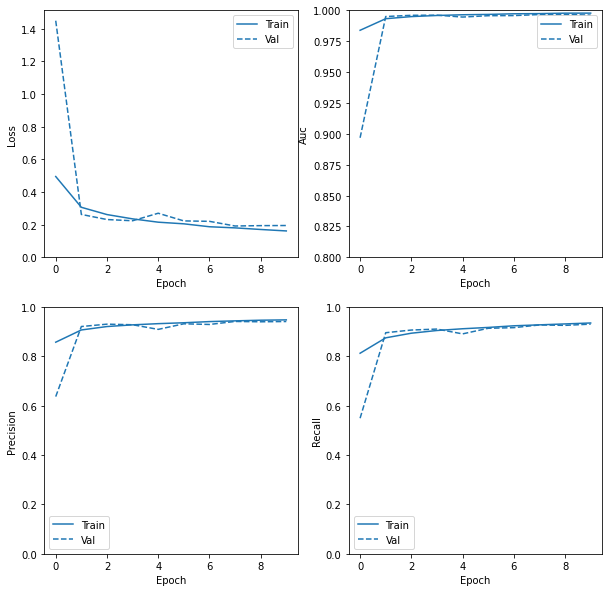

In [20]:
plot_metrics(model_history)

In [21]:
score = model.evaluate(X_test,  y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[5])

313/313 - 6s - loss: 0.2150 - tp: 9238.0000 - fp: 633.0000 - tn: 89367.0000 - fn: 762.0000 - accuracy: 0.9860 - precision: 0.9359 - recall: 0.9238 - auc: 0.9948
Test loss: 0.21500061452388763
Test accuracy: 0.9860492944717407


In [22]:
y_hat = model.predict(X_test)

In [23]:
target_names = ["Class {} ({}) :".format(i, class_names[i]) for i in range(n_classes)]
print(classification_report(np.argmax(y_test,-1), np.argmax(y_hat,-1), target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.88      0.90      0.89      1000
    Class 1 (Trouser) :       0.99      0.99      0.99      1000
   Class 2 (Pullover) :       0.88      0.92      0.90      1000
      Class 3 (Dress) :       0.93      0.94      0.93      1000
       Class 4 (Coat) :       0.88      0.90      0.89      1000
     Class 5 (Sandal) :       0.99      0.97      0.98      1000
      Class 6 (Shirt) :       0.83      0.73      0.78      1000
    Class 7 (Sneaker) :       0.95      0.98      0.96      1000
        Class 8 (Bag) :       0.99      0.98      0.99      1000
 Class 9 (Ankle boot) :       0.98      0.97      0.97      1000

               accuracy                           0.93     10000
              macro avg       0.93      0.93      0.93     10000
           weighted avg       0.93      0.93      0.93     10000



In [24]:
def plot_image(i, predictions_array, true_label, img):

    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array, -1)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [25]:
X_test_plot = X_test.reshape(X_test.shape[:-1])
y_test_plot = np.argmax(y_test,-1)

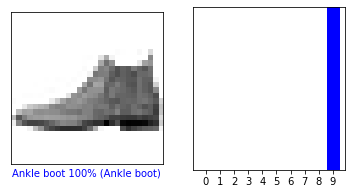

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_hat[i], y_test_plot, X_test_plot)

plt.subplot(1,2,2)
plot_value_array(i, y_hat[i],  y_test_plot)
plt.show()


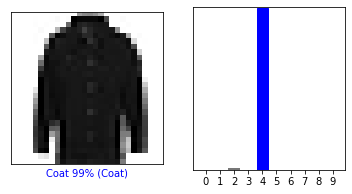

In [27]:
i = 14
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_hat[i], y_test_plot, X_test_plot)

plt.subplot(1,2,2)
plot_value_array(i, y_hat[i],  y_test_plot)
plt.show()

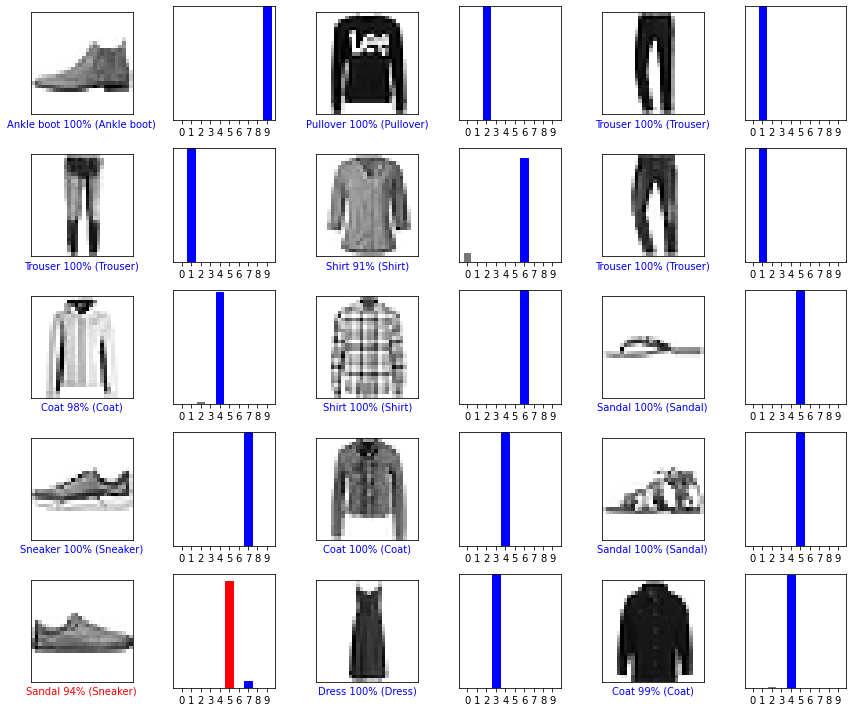

In [28]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_hat[i], y_test_plot, X_test_plot)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_hat[i],  y_test_plot)


plt.tight_layout()
plt.show()

## PyTorch